In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-future-sales-translated-dataset/shops_en.csv
/kaggle/input/predict-future-sales-translated-dataset/items_en.csv
/kaggle/input/predict-future-sales-translated-dataset/item_categories_en.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# import Library

In [2]:
import datetime #시계열 데이터 처리
import numpy as np
import pandas as pd

#시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

#전처리 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#모델 라이브러리
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance #xgboost 중요 피처 시각화

#성능 측정
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Data Set

In [3]:
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
item = pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/items_en.csv')
item_cat = pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/item_categories_en.csv')
shop = pd.read_csv('/kaggle/input/predict-future-sales-translated-dataset/shops_en.csv')
sample = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# -------

# EDA

## shop EDA

In [5]:
#기본정보
shop

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4
5,"Vologda SEC ""Marmalade""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh TRC ""Maksimir""",7
8,"Voronezh TRC City-Park ""City""",8
9,Itinerant trade,9


## Item_cat EDA

## train_merge EDA

# Data cleaning

## Cleaning 'date'

In [6]:
train["date"] = train["date"].astype("str")

#date1 :일 date2 : 월 date3 : 년
train['date1'],train['date2'],train['date3'] = train['date'].str.split(".").str

train['date_convert'] = train['date3']+'-'+train['date2']+'-'+train['date1']
train['date'] = train['date_convert']
del train['date_convert']
del train['date1']
del train['date2']
del train['date3']

train.sort_values(by='date')

train = train.sort_values(by='date')
train.reset_index(drop=True,inplace=True) 

train['date'] = pd.to_datetime(train['date'])

## Cleaning 'shop'

In [7]:
#shop의 shop_id통일 (테스트 셋에 존재하는 id 기준으로 설정)
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 11, 'shop_id'] = 10
test.loc[test['shop_id'] == 40, 'shop_id'] = 39

train.loc[train['shop_id'] == 0, 'shop_id'] = 57
train.loc[train['shop_id'] == 1, 'shop_id'] = 58
train.loc[train['shop_id'] == 11, 'shop_id'] = 10
train.loc[train['shop_id'] == 40, 'shop_id'] = 39

# !붙은 두개 제거 
shop["shop_name"][0]= shop["shop_name"][0].split("!")[1]
#shop["shop_name"][1]=shop["shop_name"][1].split("!")[0]

# 컬럼 분해해주기
shop["name1"], shop["name3"] = shop.shop_name.str.split("\"", 1).str
shop["name1"], shop["name2"] = shop.name1.str.split(" ", 1).str

# 정규식
shop = shop[['shop_name','shop_id','name1','name2','name3']]
shop['name3']= shop.name3.str.replace('[^A-Za-z]+', " ")
shop = shop.fillna('0',axis=0)

#결측치 채워주기
shop = shop.fillna('0',axis=0)

#0번 1번컬럼 바꿔주기
shop["name2"][0] = shop["name2"][0].replace("Yakutsk", "")
shop['name1'][0] = shop['shop_name'][0].split(" ")[1]
shop['name1'][1] = shop["name2"][1].split(" ")[0]
shop['name2'][1] = shop["name2"][1].split(" ")[1]

#42,43번 컬럼 붙여주기
shop['name1'][42] = shop['shop_name'][42].split(" ")[0] +  shop['shop_name'][42].split(" ")[1]
shop['name1'][43] = shop['shop_name'][43].split(" ")[0] +  shop['shop_name'][43].split(" ")[1]
shop["name2"][42] = shop["name2"][42].replace("Petersburg ", "")
shop["name2"][43] = shop["name2"][43].replace("Petersburg ", "")

#34,35번 컬럼 붙여주기
shop['name1'][34] = shop["shop_name"][34].split(" ")[0] + shop["shop_name"][34].split(" ")[1]
shop['name1'][35] = shop["shop_name"][35].split(" ")[0] + shop["shop_name"][35].split(" ")[1]
shop['name2'][34] = shop['name2'][34].replace("Novgorod", "")
shop['name2'][35] = shop['name2'][35].replace("Novgorod", "")
#46번 문자 먼저 합치기
shop['name1'][46] = shop['shop_name'][46].split(" ")[0] + shop['shop_name'][46].split(" ")[1]
shop['name2'][46] = shop['name2'][46].replace("Posad", "")
#shop['name2'].value_counts()

#name2 지정 
shop['name2']= shop.name2.str.replace('[^A-Za-z0-9]+', " ")

# name2 정렬 소문자로 겹치기
shop["name2"] = shop.name2.str.strip()
shop["name2"] = shop["name2"].str.lower()

# name2,3 0번 조정 
shop['name3'][0] = shop['name2'][0] 
shop['name2'][0] = "shop"

# name2, 4번 조정
shop["name2"][4] = "shopping center"

# name2,3 6번  조정 
shop['name3'][6] =shop['name2'][6] 
shop['name2'][6] = "shop"

# name2 8번 조정 
shop['name2'][8] = shop['name2'][8].split(" ")[0]
shop['name3'][8] = "City park"

# name2,3 10,11번 조정 
shop['name3'][10]  =shop['name2'][10] 
shop['name2'][10] = "shop"
shop['name3'][11]  =shop['name2'][11] 
shop['name2'][11] = "shop"

# name2 12번 조정
shop['name2'][12] = shop['name2'][12].split(" ")[0]
shop['name1'][12] = "online"

# name2,3 14번 조정
shop['name2'][14] ="shopping center"
shop['name3'][14] =shop['name3'][14].replace("of", "")

# name2 20번 조정 
shop['name2'][20] = "online"

# name2 21번 조정
shop['name2'][21] = 'shopping center'

# name2,3 22번 조정 
shop['name3'][22] = shop['name2'][22].split(" ")[1]
shop['name2'][22] = shop['name2'][22].split(" ")[0]

# name2 26번 조정
shop["name2"][26] = "shopping center"

# name2 33번 조정
shop['name2'][33] = 'trc'

# name2 55번 조정 
shop['name3'][55] = shop['name2'][55]
shop['name2'][55] = "online"
shop['name1'][55] = "online"

# name2,3 57번 조정 
shop['name3'][57] = shop['name2'][57] 
shop['name2'][57] = "shop"

# 컬럼명 재지정 
shop.rename(columns = {'name1':'city'}, inplace= True)
shop.rename(columns = {'name2':'place'}, inplace= True)
shop.rename(columns = {'name3':'road/place name'}, inplace= True)

#shop name 제거
shop = shop.drop('shop_name',axis=1)

## Cleaning shop2 

Text(0.5, 1.0, 'Sales by shops through time')

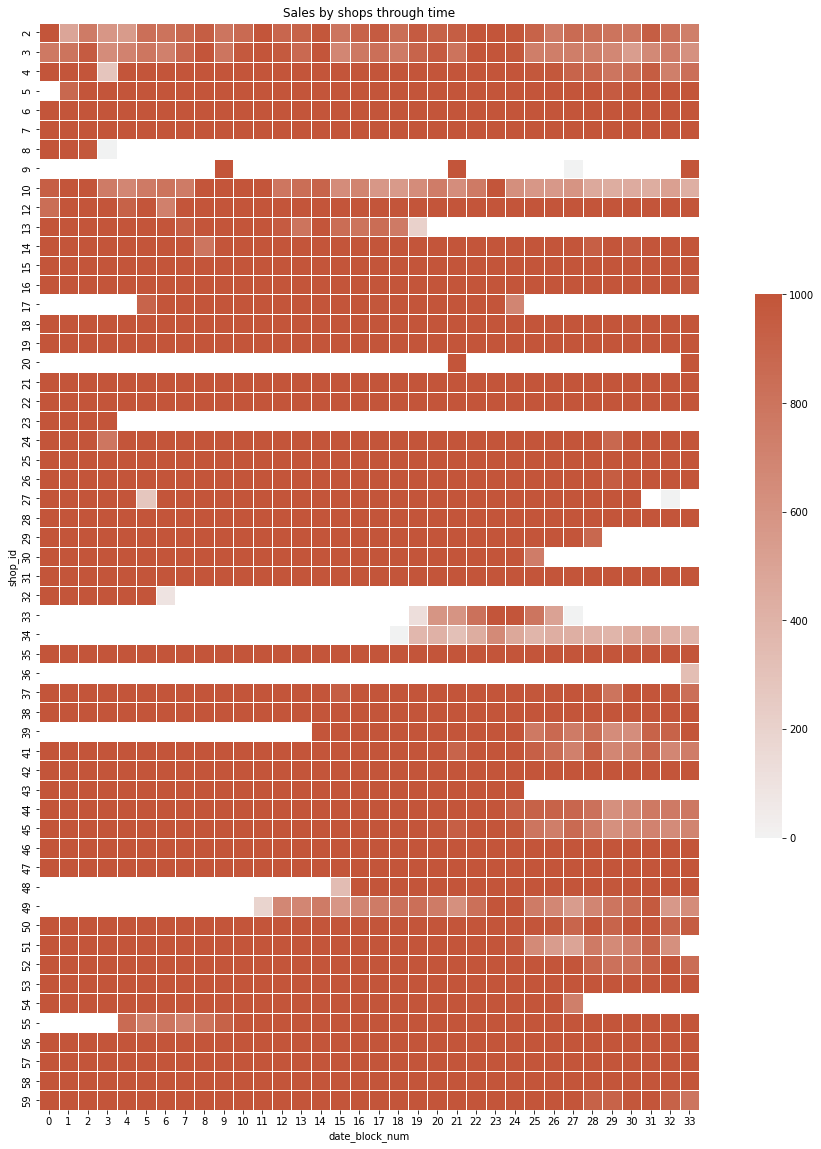

In [8]:
#월별 가게 판매량
temp_merge = pd.merge(train,shop, on='shop_id',how='left')
temp_merge = temp_merge.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()

#shop 시각화
pivot_shop_month = temp_merge.pivot_table(index="shop_id", columns="date_block_num", values="item_cnt_day", aggfunc=np.sum)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(1,1,figsize=(20,20))

sns.heatmap(pivot_shop_month, cmap=cmap, vmax=1000, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".1f").set_title("Sales by shops through time")

알 수 있는 사실 : 
- 망한 가게 : 0,1,8,23,27,32,54
- 중간에 생긴 가게 : 5,34,39,48,49,55
- 중간에 망한 가게 : 17,33,40
- 이상한 가게 : (10,11),(0,1,57,58)
- 보부상 추정되는 가게 : 9,20
- 같은 가게 추정 : (10,11) (0,57) (1,58) (39,40)

In [9]:
shop.iloc[[0,57,1,58,10,11,39,40],:]

,shop_id,city,place,road/place name
0,0,Yakutsk,shop,ordzhonikidze 56 franc
57,57,Yakutsk,shop,ordzhonikidze 56
1,1,Yakutsk,tc,Central Franc
58,58,Yakutsk,tc,Central
10,10,Zhukovsky,shop,street chkalov 39m
11,11,Zhukovsky,shop,street chkalov 39m
39,39,RostovNaDonu,trc,Megacenter Horizon
40,40,RostovNaDonu,trc,Megacenter Horizon Island


## shop 시각화

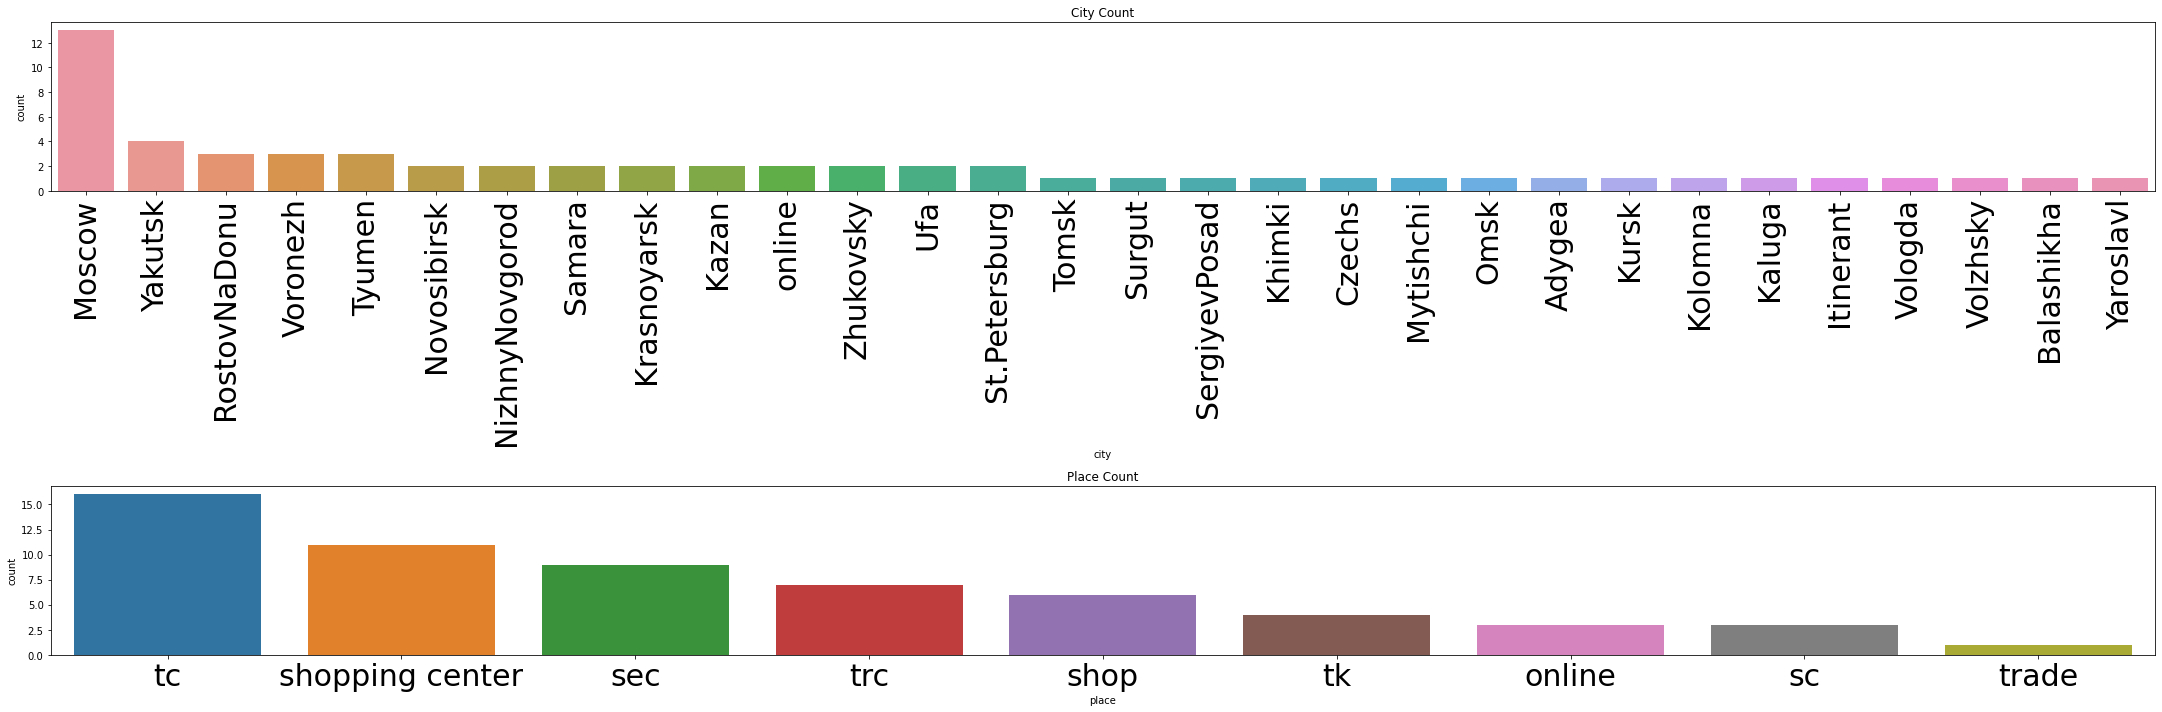

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(2,1,figsize = (30,10))
ax[0].set_title('City Count')
ax[1].set_title('Place Count')
ax[0].tick_params(axis='x',labelrotation=90,labelsize=30)
ax[1].tick_params(axis='x',labelrotation=0,labelsize=30)
sns.countplot(ax=ax[0],x='city',data=shop,order=shop['city'].value_counts().index)
sns.countplot(ax=ax[1],x='place',data=shop,order=shop['place'].value_counts().index)

#label size 바꾸기
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 10}
plt.rcParams.update(parameters)

plt.tight_layout()
plt.show()

------

# Cleaning 'item_category' 

In [11]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [12]:
# 미번역 고쳐주기
item_cat["item_category_name"][24] ='Games - XBOX ONE'

# 컬럼 두개 생성
item_cat["category"], item_cat["product"] = item_cat.item_category_name.str.split("-", 1).str

#8번값 재조정
item_cat['product'][8] = item_cat['category'][8].split("(")[1].replace(")","")
item_cat['category'][8] = item_cat['category'][8].split("(")[0]

#32번값 재조정
item_cat["product"][32] = item_cat["category"][32].split("(")[1].replace(")", "")
item_cat["category"][32] = 'Payment cards '

#36번값 재조정
item_cat['category'][36] = 'Payment cards '

#37,38 공백 정렬
item_cat["category"][37] =item_cat["category"][37].strip()
item_cat["category"][38] =item_cat["category"][38].strip()

#39,40번 이름 수정
item_cat["category"][39] = 'Movies'
item_cat["category"][40] = 'Movies'

#73~77 공백 수정
item_cat["category"][73] =item_cat["category"][73].strip()
item_cat["category"][74] =item_cat["category"][74].strip()
item_cat["category"][75] =item_cat["category"][75].strip()
item_cat["category"][76] =item_cat["category"][76].strip()
item_cat["category"][77] =item_cat["category"][77].strip()

# 78번 이름 수정
item_cat["category"][78] = "Program"

# 81,82값 묶어주기
item_cat["product"][81] = item_cat["category"][81].split("(")[1]
item_cat["product"][81] = item_cat["product"][81].replace(")", "")
item_cat["category"][81] = item_cat["category"][81].split("(")[0]

item_cat["product"][82] =item_cat["category"][82].split("(")[1]
item_cat["product"][82] = item_cat["product"][82].replace(")", "")
item_cat["category"][82] = item_cat["category"][82].split("(")[0]

#결측치 제거
item_cat.loc[item_cat['product'].isna(),'product'] = 'etc'

#item_category_name 제거
item_cat = item_cat.drop('item_category_name',axis=1)

#item_category_name 통일화
item_cat_list=['PS','XBOX','Live!','Blu-Ray','Audiobooks','Educational','Souvenirs']
for cat in item_cat_list : 
    item_cat.loc[item_cat['product'].str.contains(cat),'product'] = cat

In [13]:
#망한 가게에서만 판 item_id 없애기

temp_merge = pd.merge(train,shop, on='shop_id',how='left')

no_shop_item = set(temp_merge.loc[temp_merge['shop_id'].isin([0,1,8,23,27,32,54]),'item_id'])
shop_item = set(temp_merge.loc[temp_merge['shop_id'].isin([0,1,8,23,27,32,54])==False,'item_id'])
#len(no_shop_item - shop_item) #514개 drop!

#train데이터에 없어진 item_id 빼기
#train = train.loc[train['item_id'].isin(no_shop_item - shop_item)==False,:]
#item = item.loc[item['item_id'].isin(no_shop_item - shop_item)==False,:]

## 'item_category' 시각화

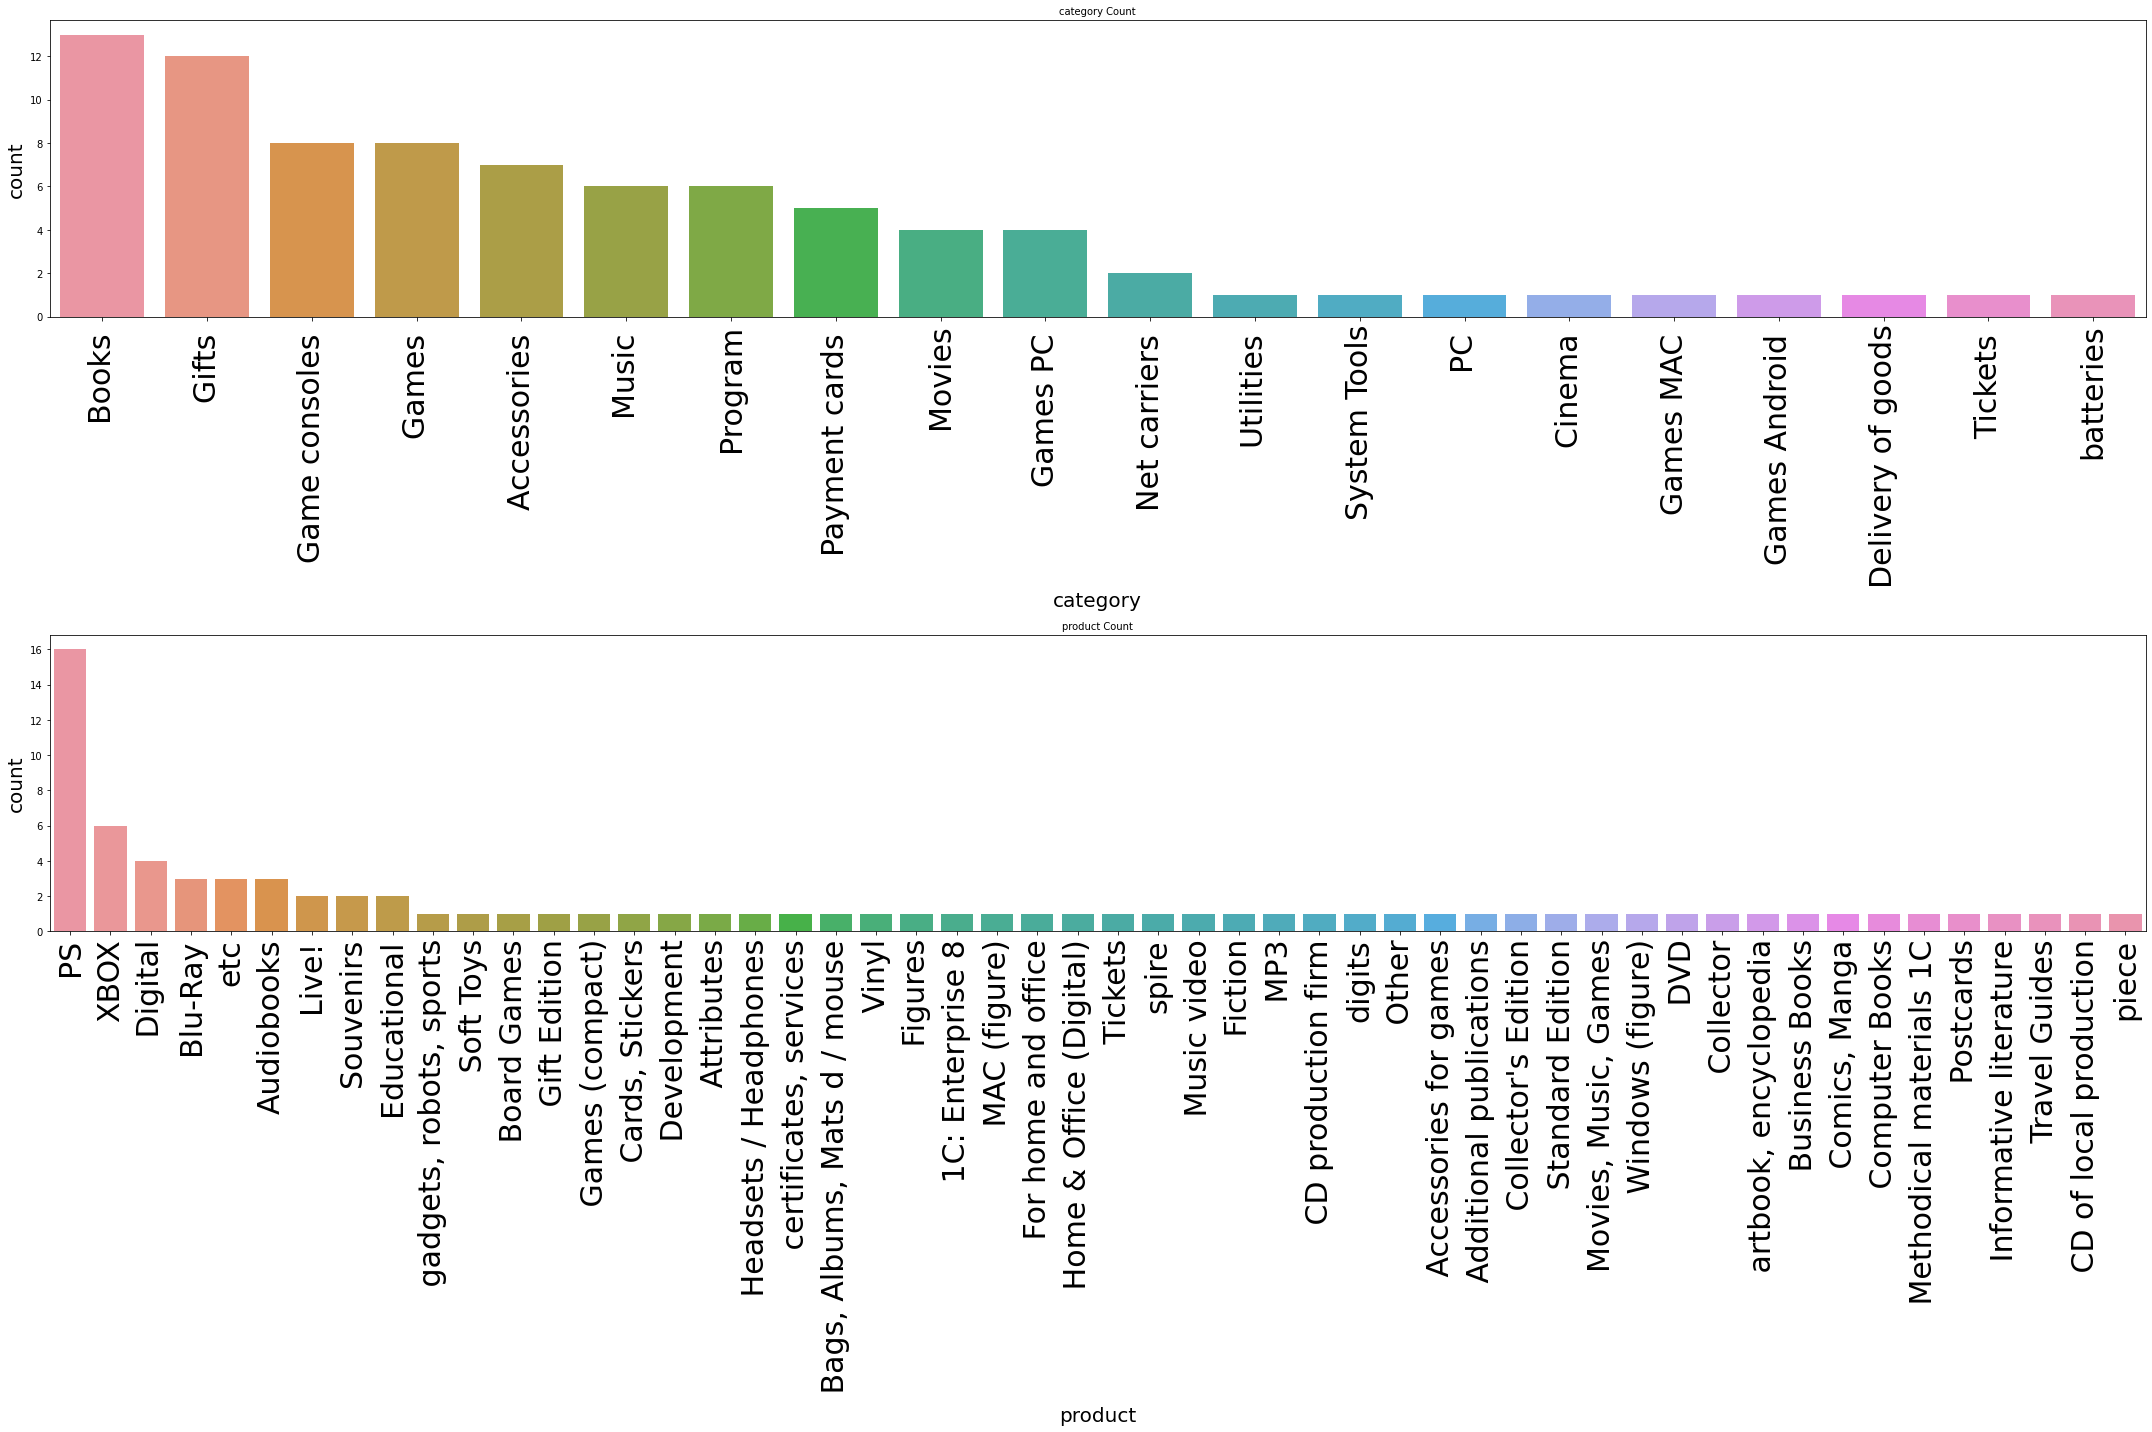

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(2,1,figsize = (30,20))
ax[0].set_title('category Count')
ax[1].set_title('product Count')
ax[0].tick_params(axis='x',labelrotation=90,labelsize=30)
ax[1].tick_params(axis='x',labelrotation=90,labelsize=30)
sns.countplot(ax=ax[0],x='category',data=item_cat,order=item_cat['category'].value_counts().index)
sns.countplot(ax=ax[1],x='product',data=item_cat,order=item_cat['product'].value_counts().index)

#label size 바꾸기
parameters = {'axes.labelsize': 10,
          'axes.titlesize': 10}
plt.rcParams.update(parameters)

plt.tight_layout()
plt.show()

# Remove unnecessary features

In [15]:
#필요없는 컬럼 drop
train = train.drop('date',axis=1)
item = item.drop('item_name',axis=1)
shop = shop.drop('road/place name',axis=1)

# Merge data&item

In [16]:
#train + item + item_categories + shop
merge_shop = pd.merge(train, shop, on = 'shop_id', how = 'left')
merge_item = pd.merge(merge_shop, item, on='item_id', how='left')
data = pd.merge(merge_item, item_cat, on='item_category_id',how='left')

In [17]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date_block_num    2935849 non-null  int64  
 1   shop_id           2935849 non-null  int64  
 2   item_id           2935849 non-null  int64  
 3   item_price        2935849 non-null  float64
 4   item_cnt_day      2935849 non-null  float64
 5   city              2935849 non-null  object 
 6   place             2935849 non-null  object 
 7   item_category_id  2935849 non-null  int64  
 8   category          2935849 non-null  object 
 9   product           2935849 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [18]:
# ??
#item_cat['category'] =item_cat.category.str.strip()
#item_cat[['category']][item_cat['category'].str.contains('Payment cards')]
#a =item_cat[['category','product']][item_cat['category'].str.contains('Accessories')]
#a = a.drop("category",axis=1)
#a.rename(columns = {'product':'Accessories'}, inplace=True)
#datacopy = datacopy.drop(["item_category_name(big)"],axis=1)

# Remove outliers

In [19]:
data.describe()
#item_price 최솟값 -1, 최댓값 30798
#item_cnt_day 최솟값 -22 최댓값 2169

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.330172e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.614678e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.800000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


<AxesSubplot:xlabel='product', ylabel='count'>

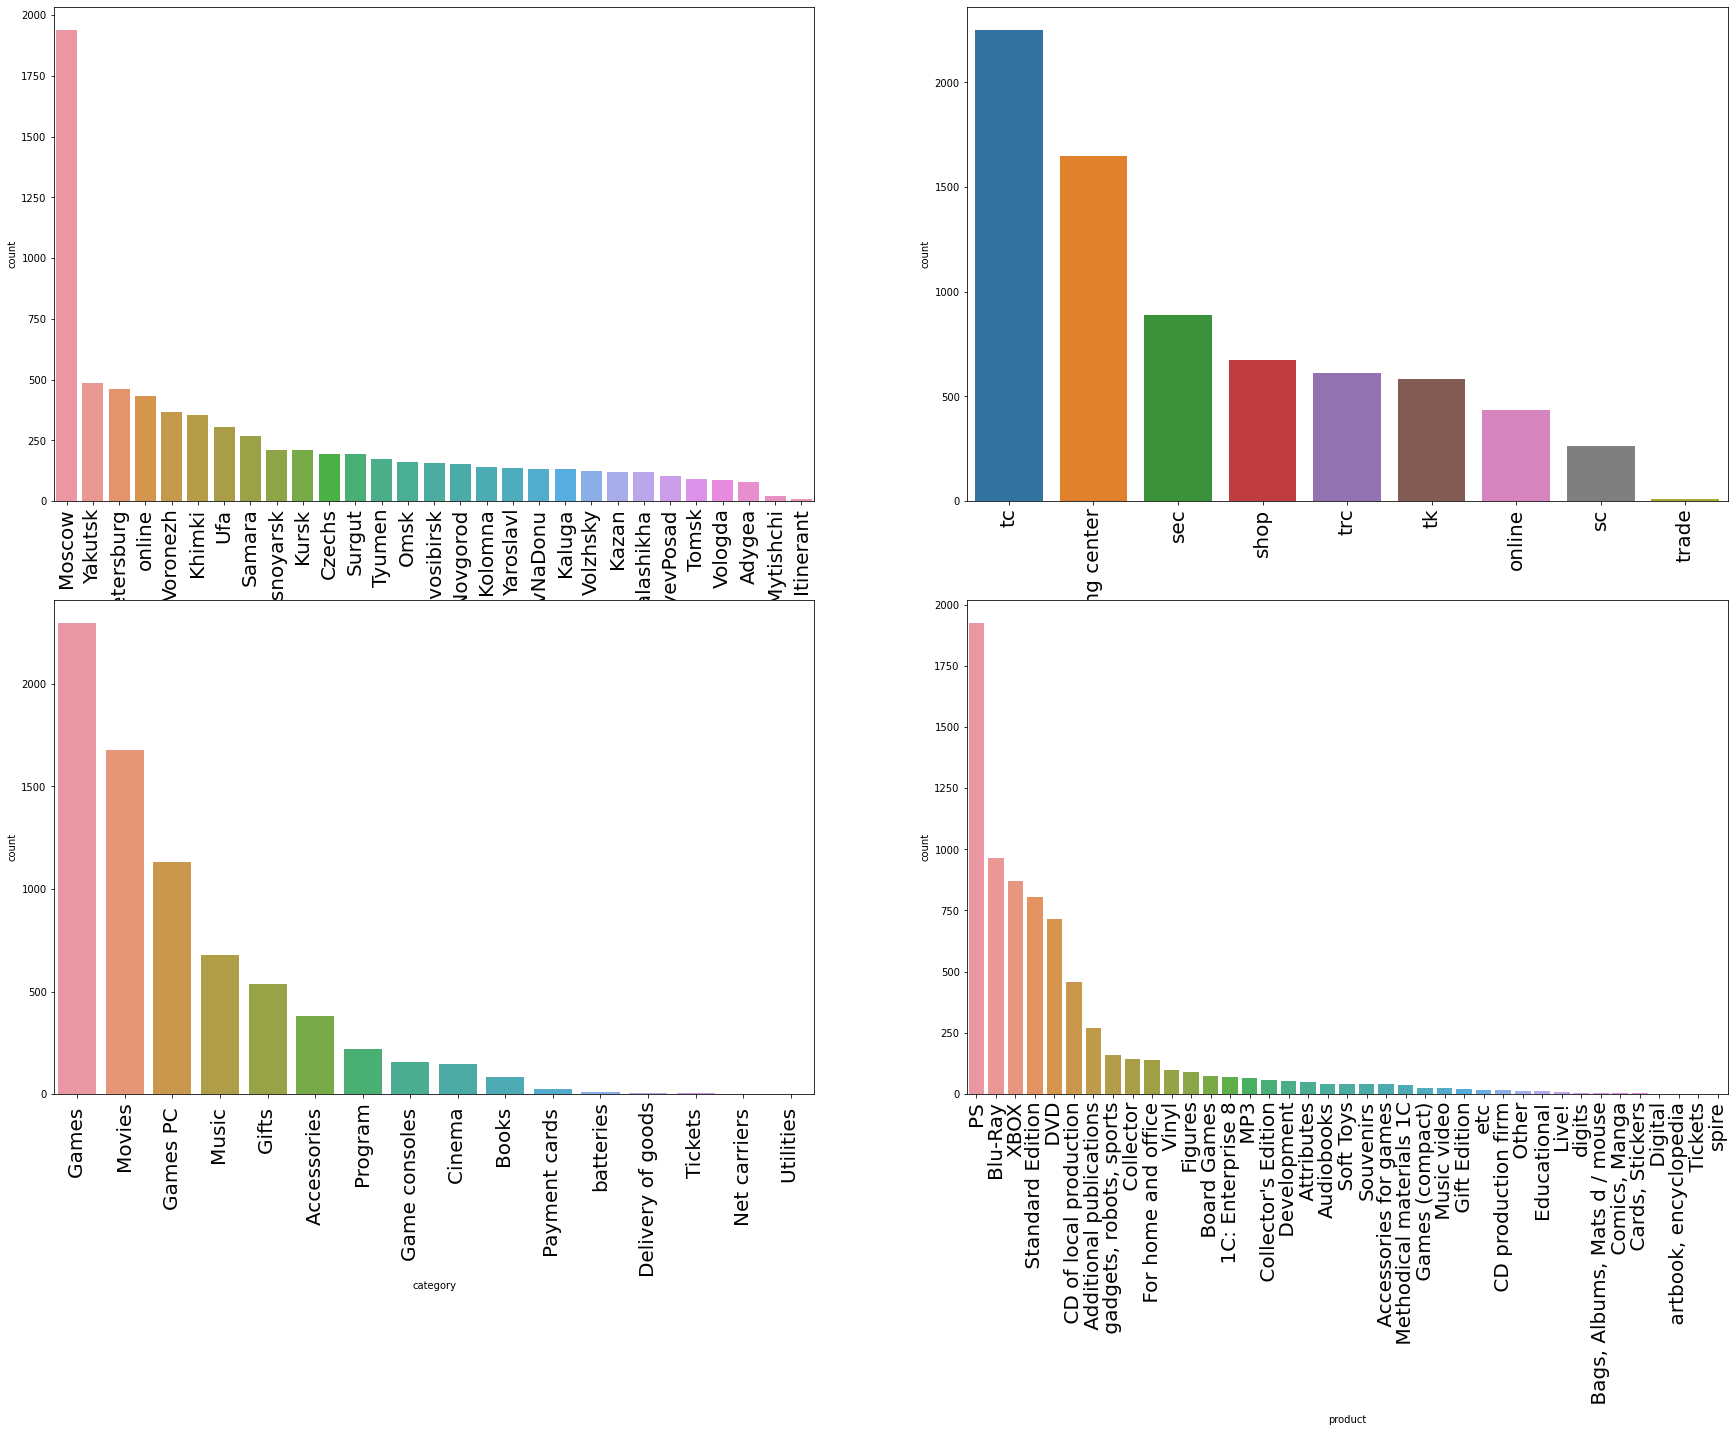

In [20]:
#cnt_day 음수인 값들 시각화
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(2,2,figsize = (30,20))

temp_df = data.loc[data['item_cnt_day']<0,:]

ax[0][0].tick_params(axis='x',labelrotation=90,labelsize=20)
ax[0][1].tick_params(axis='x',labelrotation=90,labelsize=20)
ax[1][0].tick_params(axis='x',labelrotation=90,labelsize=20)
ax[1][1].tick_params(axis='x',labelrotation=90,labelsize=20)
sns.countplot(ax=ax[0][0],x='city',data=temp_df,order=temp_df['city'].value_counts().index)
sns.countplot(ax=ax[0][1],x='place',data=temp_df,order=temp_df['place'].value_counts().index)
sns.countplot(ax=ax[1][0],x='category',data=temp_df,order=temp_df['category'].value_counts().index)
sns.countplot(ax=ax[1][1],x='product',data=temp_df,order=temp_df['product'].value_counts().index)

<AxesSubplot:xlabel='item_price'>

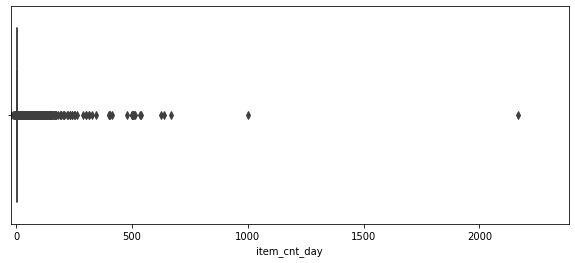

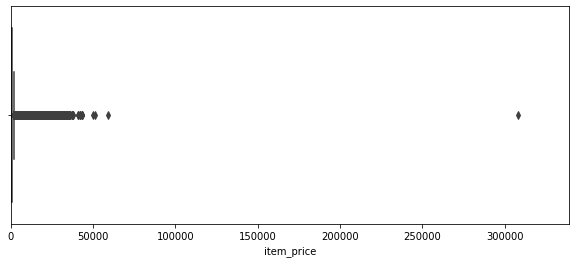

In [21]:
# item_cnt_day 이상치 체크
plt.figure(figsize=(10,4))
plt.xlim(data.item_cnt_day.min()*1.1,  data.item_cnt_day.max()*1.1)
sns.boxplot(x=data.item_cnt_day)
#item_price 이상치 체크
plt.figure(figsize=(10,4))
plt.xlim(data.item_price.min(), data.item_price.max()*1.1) #item_price의 최소값 최대값을 x축으로 지정
sns.boxplot(x=data.item_price)

In [22]:
train = train[(train.item_price > 0) &(train.item_price < 100000) & \
            (train.item_cnt_day > 0)& (train.item_cnt_day < 1000)]

# Label Encoding

In [23]:
#shop, item_category 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

shop['city'] = LabelEncoder().fit_transform(shop['city'])
shop['place'] = LabelEncoder().fit_transform(shop['place'])

item_cat['category'] = LabelEncoder().fit_transform(item_cat['category'])
item_cat['product'] = LabelEncoder().fit_transform(item_cat['product'])

-----

# 여기까지 EDA 완료

# Groupby data (make new data)

In [24]:

#월 ID별로 한 번이라도 등장한 상점 ID, 상품 ID로 조합 만들기
from itertools import product
import time
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    all_shop = train.loc[train['date_block_num']==i,'shop_id'].unique()
    all_item = train.loc[train['date_block_num']==i,'item_id'].unique()
    matrix.append( np.array(list( product( [i], all_shop, all_item))))

#리스트인 matrix를 DataFrame타입으로 변환
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )

#다운캐스트
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)

#재정렬
matrix.sort_values(cols, inplace = True )


## Make 'item_cnt_month' : 월별 상점별 아이템별 아이템 판매량

In [25]:
#월별 상점별 아이템 판매량
group = train.groupby(cols).agg({"item_cnt_day":'sum'})
group.columns = ['item_cnt_month']

matrix = pd.merge(matrix,group,on=cols,how="left")
matrix['item_cnt_month']=matrix['item_cnt_month'].fillna(0)

-----

# Make test set 

In [26]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

#test 데이터 ID 컬럼 제거
test.drop(["ID"],axis=1, inplace=True)

#test 데이터 새로 만든 matrix 데이터와 합체
matrix = pd.concat([matrix, test], ignore_index = True, sort= False, keys =cols)
matrix['item_cnt_month']=matrix['item_cnt_month'].fillna(0).astype(np.int16)

# 사용할 최종 데이터 만들기

In [27]:
matrix = pd.merge(matrix, shop, on='shop_id',how='left')
matrix = pd.merge(matrix, item, on='item_id',how='left')
matrix = pd.merge(matrix, item_cat, on='item_category_id',how='left')

#다운 캐스트
matrix['city']=matrix['city'].astype(np.int8)
matrix['place']=matrix['place'].astype(np.int8)
matrix['item_category_id']=matrix['item_category_id'].astype(np.int8)
matrix['category']=matrix['category'].astype(np.int8)
matrix['product']=matrix['product'].astype(np.int16)

In [28]:
#메모리 관리 : 사용한 데이터셋 제거 
del shop
del item
del item_cat

# Lag data

In [29]:
def lag_feature( df,lags, cols ):
    for col in cols:
        #print(col)
        #임시 df 생성
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            #임시 데이터 복사
            shifted = tmp.copy() 
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            #임시 데이터 컬럼 + lag 수
            shifted.date_block_num = shifted.date_block_num + i
            #원본 데이터에 컬럼 데이터 합치기 
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [30]:
matrix = lag_feature(matrix , [1,2,3], ["item_cnt_month"])

In [31]:
for i in range(1,4):
    name = 'item_cnt_month_lag_'+str(i)
    matrix[name] = matrix[name].astype(np.float16)

-----

# lag_feature 만들기

In [32]:
def add_lag_feature(matrix,group_cols,new_col_name,lags,cal_col='item_cnt_month',train=None):
    if train is None:
        group = matrix.groupby(group_cols).agg({cal_col:'mean'})
    else :
        group = train.groupby(group_cols).agg({cal_col:'mean'})
    group = group.reset_index()
    group = group.rename(columns={cal_col:new_col_name[0]})

    #새로만든 matrix와 그룹화한 데이터 컬럼의 lag 컬럼만 merge
    matrix =pd.merge(matrix,group, on = group_cols, how="left")

    matrix.loc[:,new_col_name] = matrix.loc[:,new_col_name].astype(np.float16)
    matrix = lag_feature(matrix,lags, new_col_name)
    matrix.drop(new_col_name, axis=1, inplace=True)
    print(f"{new_col_name}_lag 생성 완료")
    return matrix

In [33]:
#월별_평균_상품개수
matrix = add_lag_feature(matrix = matrix,
                           group_cols = ['date_block_num'],
                           new_col_name = ['month_avg_item_cnt'],
                           lags = [1],
                           cal_col = "item_cnt_month")
#월_상품별_평균_상품개수
matrix = add_lag_feature(matrix,
                           ['date_block_num','item_id'],
                           ['month_item_avg_item_cnt'],
                           [1,3,12])
#월_가게_상품별_평균_상품개수
# matrix = add_lag_feature(matrix,
#                            ['date_block_num','shop_id','item_id'],
#                            ['month_shop_item_avg_item_cnt'],
#                            [1,3,12])
#월_도시별_평균_상품개수
matrix = add_lag_feature(matrix,
                           ['date_block_num','city'],
                           ['month_city_avg_item_cnt']
                           ,[1,3,12])
#월_도시_상품별_상품개수
matrix = add_lag_feature(matrix,
                           ['date_block_num','city','item_id'],
                           ['month_city_item_avg_item_cnt'],
                           [1,3,12])
#월_도시_가게별_상품개수
matrix = add_lag_feature(matrix,
                           ['date_block_num','city','shop_id'],
                           ['month_city_shop_avg_item_cnt'],
                           [1,3,12])
# #월_도시_가게_상품별_상품개수
# matrix = add_lag_feature(matrix,
#                            ['date_block_num','city','shop_id','item_id'],
#                            ['month_city_shop_item_avg_item_cnt'],
#                            [1,3,12])

['month_avg_item_cnt']_lag 생성 완료
['month_item_avg_item_cnt']_lag 생성 완료
['month_city_avg_item_cnt']_lag 생성 완료
['month_city_item_avg_item_cnt']_lag 생성 완료
['month_city_shop_avg_item_cnt']_lag 생성 완료


In [34]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11027015 entries, 0 to 11027014
Data columns (total 25 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   date_block_num                       int8   
 1   shop_id                              int8   
 2   item_id                              int16  
 3   item_cnt_month                       int16  
 4   city                                 int8   
 5   place                                int8   
 6   item_category_id                     int8   
 7   category                             int8   
 8   product                              int16  
 9   item_cnt_month_lag_1                 float16
 10  item_cnt_month_lag_2                 float16
 11  item_cnt_month_lag_3                 float16
 12  month_avg_item_cnt_lag_1             float16
 13  month_item_avg_item_cnt_lag_1        float16
 14  month_item_avg_item_cnt_lag_3        float16
 15  month_item_avg_item_cnt_lag_12

----

## Make Other Lag

In [35]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,18,5823,2500.0,1.0
1,0,27,5573,849.0,1.0
2,0,7,1006,399.0,1.0
3,0,19,17707,899.0,1.0
4,0,14,19548,149.0,1.0


## price lag

In [36]:
# 상품당 상품 가격
group = train.groupby('item_id').agg({"item_price":'mean'})
group = group.reset_index()
group = group.rename(columns={'item_price':'item_avg_item_price'})

matrix = pd.merge(matrix,group, on='item_id',how='left')
matrix["item_avg_item_price"] = matrix["item_avg_item_price"].astype(np.float16)
# 월간 상품당 상품 가격
lags=[1,3,12]
matrix=add_lag_feature(matrix,
                      group_cols = ['date_block_num','item_id'],
                      new_col_name=['month_item_avg_item_price'],
                      lags=lags,
                      cal_col='item_price',
                      train=train)

'''
train=pd.merge(train,shop,on='shop_id',how='left')
#도시당 상품 가격
matrix=add_lag_feature(matrix,
                      group_cols = ['city','item_id'],
                      new_col_name=['city_item_avg_item_price'],
                      lags=[1,3,12],
                      cal_col='item_price',
                      train=train)
#월간 도시당 상품 가격
matrix=add_lag_feature(matrix,
                      group_cols = ['date_block_num','city','item_id'],
                      new_col_name=['month_city_item_avg_item_price'],
                      lags=[1,3,12],
                      cal_col='item_price',
                      train=train)
#온라인 오프라인당 상품 가격
'''

['month_item_avg_item_price']_lag 생성 완료


"\ntrain=pd.merge(train,shop,on='shop_id',how='left')\n#도시당 상품 가격\nmatrix=add_lag_feature(matrix,\n                      group_cols = ['city','item_id'],\n                      new_col_name=['city_item_avg_item_price'],\n                      lags=[1,3,12],\n                      cal_col='item_price',\n                      train=train)\n#월간 도시당 상품 가격\nmatrix=add_lag_feature(matrix,\n                      group_cols = ['date_block_num','city','item_id'],\n                      new_col_name=['month_city_item_avg_item_price'],\n                      lags=[1,3,12],\n                      cal_col='item_price',\n                      train=train)\n#온라인 오프라인당 상품 가격\n"

In [37]:
# delta price lag 만들기 : (월간 아이템 평균 price lag - 아이템 평균 price lag) / (평균 price lag)
#실패작
'''
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["month_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]
    
def mean_delta_price_lag(row):
    total=0
    cnt=0
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            total+=row["delta_price_lag_" + str(i)]
            cnt+=1
    if total == 0 :
        return 0
    else : 
        total /= cnt
        return total


matrix['delta_price_lag'] = matrix.apply(mean_delta_price_lag ,axis=1) 
matrix["delta_price_lag"] = matrix["delta_price_lag"].fillna(0,inplace = True)
features_to_drop = ["item_avg_item_price"]

for i in lags:
    features_to_drop.append("month_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
matrix['delta_price_lag'].unique()
'''

'\nfor i in lags:\n    matrix["delta_price_lag_" + str(i) ] = (matrix["month_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]\n    \ndef mean_delta_price_lag(row):\n    total=0\n    cnt=0\n    for i in lags:\n        if row["delta_price_lag_" + str(i)]:\n            total+=row["delta_price_lag_" + str(i)]\n            cnt+=1\n    if total == 0 :\n        return 0\n    else : \n        total /= cnt\n        return total\n\n\nmatrix[\'delta_price_lag\'] = matrix.apply(mean_delta_price_lag ,axis=1) \nmatrix["delta_price_lag"] = matrix["delta_price_lag"].fillna(0,inplace = True)\nfeatures_to_drop = ["item_avg_item_price"]\n\nfor i in lags:\n    features_to_drop.append("month_item_avg_item_price_lag_" + str(i) )\n    features_to_drop.append("delta_price_lag_" + str(i) )\nmatrix.drop(features_to_drop, axis = 1, inplace = True)\nmatrix[\'delta_price_lag\'].unique()\n'

## revenue lag

In [38]:
# revenue(이득) feature 생성
train['revenue'] = train['item_cnt_day'] * train['item_price']

In [39]:
#월간 가게 총 매출
group = train.groupby(["date_block_num","shop_id"]).agg({"revenue":"sum"})
group.columns = ["month_shop_revenue"]
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on = ["date_block_num","shop_id"], how="left")
matrix["month_shop_revenue"] = matrix["month_shop_revenue"].astype(np.float32)

#가게 평균 오픈일
group = group.groupby(["shop_id"]).agg({"date_block_num":["mean"]})
group.columns = ["shop_avg_month"]
group.reset_index(inplace=True)

matrix = matrix.merge(group, on = ["shop_id"],how="left")
matrix["shop_avg_month"] = matrix['shop_avg_month'].astype(np.float32)

#delta_cnt_price
matrix["delta_shop_revenue"] = (matrix['month_shop_revenue']- matrix['shop_avg_month'])/ matrix['month_shop_revenue']
matrix["delta_shop_revenue"] = matrix["delta_shop_revenue"].astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_shop_revenue"])
matrix["delta_shop_revenue_lag_1"] = matrix["delta_shop_revenue_lag_1"].astype(np.float32)
matrix.drop(["month_shop_revenue", "shop_avg_month", "delta_shop_revenue"],axis= 1, inplace=True)

In [40]:
matrix = matrix[matrix["date_block_num"]>11]

In [41]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6548171 entries, 4478844 to 11027014
Data columns (total 30 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   date_block_num                       int8   
 1   shop_id                              int8   
 2   item_id                              int16  
 3   item_cnt_month                       int16  
 4   city                                 int8   
 5   place                                int8   
 6   item_category_id                     int8   
 7   category                             int8   
 8   product                              int16  
 9   item_cnt_month_lag_1                 float16
 10  item_cnt_month_lag_2                 float16
 11  item_cnt_month_lag_3                 float16
 12  month_avg_item_cnt_lag_1             float16
 13  month_item_avg_item_cnt_lag_1        float16
 14  month_item_avg_item_cnt_lag_3        float16
 15  month_item_avg_item_cnt_l

# Modeling 